In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint

In [11]:
import os

results_path = "/home/jason/Applications/omnetpp-6.0.1/samples/florasat/simulations/dtsiot/results"
data_dir = "data"

rebuild_csv = True
if rebuild_csv:
    sca_files = [f for f in os.listdir(results_path) if f.endswith(".sca")]
    vec_files = [f for f in os.listdir(results_path) if f.endswith(".vec")]


    for file_name in sca_files + vec_files:
        print(file_name)
        os.system(f"opp_scavetool x {os.path.join(results_path, file_name)} -o {os.path.join(data_dir, file_name)}.csv")


sca_files = [f for f in os.listdir(data_dir) if ".sca" in f]
vec_files = [f for f in os.listdir(data_dir) if ".vec" in f]

dfs = {
    "RESS-IoT": {
        "SCA": {},
        "VEC": {},
    },
    "DQ": {
        "SCA": {},
        "VEC": {},
    }
}

for file_name in sca_files + vec_files:
    print(file_name)
    df = pd.read_csv(f"{os.path.join(data_dir, file_name)}", dtype=str)
    
    if ".sca" in file_name:
        numNodes = int(df.loc[df['name'] == 'nrOfNodes'].value.iloc[0])
        file_type = "SCA"
    elif ".vec" in file_name:
        numNodes = int(df.loc[df['attrname'] == "**.nrOfNodes"].attrvalue.iloc[0])
        file_type = "VEC"
    
    if "RESS-IoT" in file_name:
        protocol = "RESS-IoT"
    elif "DQ" in file_name:
        protocol = "DQ"
    
    try:
        dfs[protocol][file_type][numNodes].append(df)
    except KeyError:
        dfs[protocol][file_type][numNodes] = [df]

for protocol in dfs:
    node_counts = list(dfs[protocol]["SCA"].keys())
    node_counts.sort()
    
    dfs[protocol]["SCA"] = {node_count: dfs[protocol]["SCA"][node_count] for node_count in node_counts}
    dfs[protocol]["VEC"] = {node_count: dfs[protocol]["VEC"][node_count] for node_count in node_counts}

pd.set_option('display.max_rows', None)   

df = None

RESS-IoT-N=10-#0.sca
Exported 41 scalars, 3001 parameters
DQ-N=100-#1.sca
Exported 695 scalars, 14800 parameters
DQ-N=100-#0.sca
Exported 694 scalars, 14800 parameters
RESS-IoT-N=100-#1.sca
Exported 262 scalars, 14701 parameters
DQ-N=10-#1.sca
Exported 79 scalars, 3010 parameters
RESS-IoT-N=100-#0.sca
Exported 269 scalars, 14701 parameters
RESS-IoT-N=10-#1.sca
Exported 41 scalars, 3001 parameters
DQ-N=10-#0.sca
Exported 79 scalars, 3010 parameters
DQ-N=10-#1.vec
Exported 10 vectors
RESS-IoT-N=100-#1.vec
Exported 52 vectors
DQ-N=100-#1.vec
Exported 86 vectors
RESS-IoT-N=100-#0.vec
Exported 59 vectors
DQ-N=10-#0.vec
Exported 10 vectors
DQ-N=100-#0.vec
Exported 87 vectors
RESS-IoT-N=10-#0.vec
Exported 11 vectors
RESS-IoT-N=10-#1.vec
Exported 11 vectors
DQ-N=100-#1.sca.csv
DQ-N=100-#0.sca.csv
DQ-N=10-#1.sca.csv
RESS-IoT-N=10-#0.sca.csv
RESS-IoT-N=100-#1.sca.csv
RESS-IoT-N=10-#1.sca.csv
DQ-N=10-#0.sca.csv
RESS-IoT-N=100-#0.sca.csv
DQ-N=100-#0.vec.csv
RESS-IoT-N=100-#1.vec.csv
DQ-N=10-#1.vec

In [12]:
def get_throughput_bytes_per_hour(df):
    # Throughput B / hr
    sim_time_hours = float(df.loc[df['name'] == 'simulated time'].value.iloc[0]) / 60 / 60
    bytes_per_data_packet = int(df.loc[df['name'] == 'dataPacketLenBits'].value.iloc[0]) / 8
    num_data_packets = int(df.loc[df['name'] == 'numDataPacketsReceived'].value.iloc[0])

    return (num_data_packets * bytes_per_data_packet) / sim_time_hours

def get_jfi(df):
    # Jain's Fairness Index
    num_nodes = int(df.loc[df['name'] == 'nrOfNodes'].value.iloc[0])
    denominator = num_nodes * df[df['name'].str.startswith('numDataPacketsReceivedByNodeId', na=False)].value.astype(int).pow(2).sum()
    numerator =  df[df['name'].str.startswith('numDataPacketsReceivedByNodeId', na=False)].value.astype(int).sum() ** 2.0
    jfi = numerator / denominator if denominator != 0 else 0
    return jfi

def get_overhead_bytes(df):
    # Total bytes of overhead (Beacon, RTS, VCTS) or (ARS, FBP)
    possible_keys = [
        ('numARSPacketsSent', 'arsPacketLenBits'),
        ('numFBPPacketsSent', 'fbpPacketLenBits'),
        ('numRTSPacketsSent', 'rtsPacketLenBits'),
        ('numBeaconPacketsSent', 'beaconPacketLenBits'),
        ('numVCTSPacketsSent', 'vctsPacketLenBits'),
    ]
    
    overhead_bits = 0
    for key in possible_keys:
        try:
            total_num_packets = df.loc[df['name'] == key[0]].value.astype(int).sum()
            bits_per_packet = int(df.loc[df['name'] == key[1]].value.iloc[0])
            overhead_bits += (total_num_packets * bits_per_packet)
        except IndexError:
            pass

    return overhead_bits / 8

def get_data_bytes(df):
    bits_per_data_packet = int(df.loc[df['name'] == 'dataPacketLenBits'].value.iloc[0])
    num_data_packets = int(df.loc[df['name'] == 'numDataPacketsReceived'].value.iloc[0])

    return bits_per_data_packet * num_data_packets / 8

def get_avg_delay(df_sca, df_vec):
    num_data_packets = int(df_sca.loc[df_sca['name'] == 'numDataPacketsReceived'].value.iloc[0])

    rows = df_vec.loc[(df_vec['name'] == "dataPacketDelays:vector") & (df_vec['type'] == "vector")].vecvalue
    total_delay = 0
    for row in rows:
        for delay in row.split(" "):
            total_delay += float(delay)
            
    return total_delay / num_data_packets

def get_energy_satellite_DQ(df_sca, df_vec):
    p_rx = 25.74 / 1000 # W
    p_tx = 389.4 / 1000 # W
    
    num_rounds = int(df_sca.loc[df_sca['name'] == "numFBPPacketsSent"].value.iloc[0])
    
    # Sat always sends a FBP
    t_fbp = float(df_sca.loc[df_sca['name'] == "fbpPacketTime"].value.iloc[0])
    e_fbp = num_rounds * p_tx * t_fbp
    
    # Sat always listens for all contention slots
    t_ars = float(df_sca.loc[df_sca['name'] == "arsPacketTime"].value.iloc[0])
    n_slots = int(df_sca.loc[df_sca['name'] == "numContentionSlots"].value.iloc[0])
    e_ars = num_rounds * p_rx * t_ars * n_slots
    
    # Sat only listens when a data packet will be sent len(dtq) != 0
    t_data = float(df_sca.loc[df_sca['name'] == "dataPacketTime"].value.iloc[0])
    num_data_packets = float(df_sca.loc[df_sca['name'] == "numDataPacketsReceived"].value.iloc[0])
    e_data = num_data_packets * p_rx * t_data
    
    return e_fbp + e_ars + e_data

def get_energy_node_DQ(df_sca, df_vec):
    p_rx = 25.74 / 1000 # W
    p_tx = 389.4 / 1000 # W
    
    num_rounds = int(df_sca.loc[df_sca['name'] == "numFBPPacketsSent"].value.iloc[0])
    num_nodes = int(df_sca.loc[df_sca['name'] == 'nrOfNodes'].value.iloc[0])

    # Nodes always listen for FBP
    t_fbp = float(df_sca.loc[df_sca['name'] == "fbpPacketTime"].value.iloc[0])
    e_fbp = num_nodes * num_rounds * p_rx * t_fbp
    
    # Nodes only send ARS when the constraints are met
    t_ars = float(df_sca.loc[df_sca['name'] == "arsPacketTime"].value.iloc[0])
    total_num_ars_packets_sent = df_sca.loc[df_sca['name'] == "numARSPacketsSent"].value.astype(int).sum()
    e_ars = total_num_ars_packets_sent * p_tx * t_ars
    
    # Only one or zero data packets can be sent each round
    t_data = float(df_sca.loc[df_sca['name'] == "dataPacketTime"].value.iloc[0])
    num_data_packets = float(df_sca.loc[df_sca['name'] == "numDataPacketsReceived"].value.iloc[0])
    e_data = num_data_packets * p_tx * t_data
    
    return e_fbp + e_ars + e_data

def get_energy_satellite_RESSIOT(df_sca, df_vec):
    p_rx = 25.74 / 1000 # W
    p_tx = 389.4 / 1000 # W
        
    num_rounds = int(df_sca.loc[df_sca['name'] == "numBeaconPacketsSent"].value.iloc[0])

    t_beacon = float(df_sca.loc[df_sca['name'] == "beaconPacketTime"].value.iloc[0])
    w_rx = float(df_sca.loc[df_sca['name'] == "wrx"].value.iloc[0])
    e_rp_sat = (p_tx * t_beacon) + (p_rx * w_rx)
    
    e_tp_sat = 0
    t_vcts = float(df_sca.loc[df_sca['name'] == "vctsPacketTime"].value.iloc[0])
    t_data = float(df_sca.loc[df_sca['name'] == "dataPacketTime"].value.iloc[0])
        
    vcts_sizes = df_vec.loc[(df_vec['name'] == "vctsSizes:vector") & (df_vec['type'] == "vector")].vecvalue.iloc[0].split(" ")
    for vcts_size in vcts_sizes:
        e_tp_sat += (p_tx * t_vcts) + (int(vcts_size) * p_rx * t_data)
    
    return (num_rounds * e_rp_sat) + e_tp_sat

def get_energy_node_RESSIOT(df_sca, df_vec):
    p_rx = 25.74 / 1000 # W
    p_tx = 389.4 / 1000 # W
        
    num_rounds = int(df_sca.loc[df_sca['name'] == "numBeaconPacketsSent"].value.iloc[0])
    num_nodes = int(df_sca.loc[df_sca['name'] == 'nrOfNodes'].value.iloc[0])

    t_beacon = float(df_sca.loc[df_sca['name'] == "beaconPacketTime"].value.iloc[0])
    t_rts = float(df_sca.loc[df_sca['name'] == "rtsPacketTime"].value.iloc[0])
    total_num_rts_packets_sent = df_sca.loc[df_sca['name'] == "numRTSPacketsSent"].value.astype(int).sum()
    e_rp_nodes = (num_nodes * num_rounds * p_rx * t_beacon) + (total_num_rts_packets_sent * p_tx * t_rts)
    
    e_tp_nodes = 0
    t_vcts = float(df_sca.loc[df_sca['name'] == "vctsPacketTime"].value.iloc[0])
    t_data = float(df_sca.loc[df_sca['name'] == "dataPacketTime"].value.iloc[0])
    
    vcts_sizes = df_vec.loc[(df_vec['name'] == "vctsSizes:vector") & (df_vec['type'] == "vector")].vecvalue.iloc[0].split(" ")
    for vcts_size in vcts_sizes:
        e_tp_nodes += (num_nodes * p_rx * t_vcts) + (int(vcts_size) * p_tx * t_data)
    
    return e_rp_nodes + e_tp_nodes

def get_avg_energy_efficiency_node(key, df_sca, df_vec):
    if key == "RESS-IoT": 
        e_nodes = get_energy_node_RESSIOT(df_sca, df_vec)
    elif key == "DQ":
        e_nodes = get_energy_node_DQ(df_sca, df_vec)

    num_nodes = int(df_sca.loc[df_sca['name'] == 'nrOfNodes'].value.iloc[0])
    e_node_avg = e_nodes / num_nodes
    
    return get_data_bytes(df_sca) / e_node_avg
    
def get_energy_efficiency_satellite(key, df_sca, df_vec):
    if key == "RESS-IoT": 
        e_sat = get_energy_satellite_RESSIOT(df_sca, df_vec)
    elif key == "DQ":
        e_sat = get_energy_satellite_DQ(df_sca, df_vec)
    
    return get_data_bytes(df_sca) / e_sat

def get_energy_efficiency_network(key, df_sca, df_vec):
    if key == "RESS-IoT": 
        e_network = get_energy_satellite_RESSIOT(df_sca, df_vec) + get_energy_node_RESSIOT(df_sca, df_vec)
    elif key == "DQ":
        e_network = get_energy_satellite_DQ(df_sca, df_vec) + get_energy_node_DQ(df_sca, df_vec)
    
    return get_data_bytes(df_sca) / e_network

{'DQ': {10: {'Average Delay [seconds]': 5.866112525745671,
             'Average Energy Efficiency per Node [bytes / joule]': 1051.3720705839548,
             'Data': 4819.5,
             'Jain Fairness Index': 0.8996764879895871,
             'Network Energy Efficiency [bytes / joule]': 64.10120142086247,
             'Overhead': 2274.5,
             'Satellite Energy Efficiency [bytes / joule]': 164.2884235764672,
             'Throughput [bytes / hour]': 43375.5},
        100: {'Average Delay [seconds]': 146.16427995234687,
              'Average Energy Efficiency per Node [bytes / joule]': 4252.68400978764,
              'Data': 9292.5,
              'Jain Fairness Index': 0.7216963755199048,
              'Network Energy Efficiency [bytes / joule]': 37.94317221653559,
              'Overhead': 3328.0,
              'Satellite Energy Efficiency [bytes / joule]': 352.03654416639523,
              'Throughput [bytes / hour]': 83632.5}},
 'RESS-IoT': {10: {'Average Delay [seconds]': 2

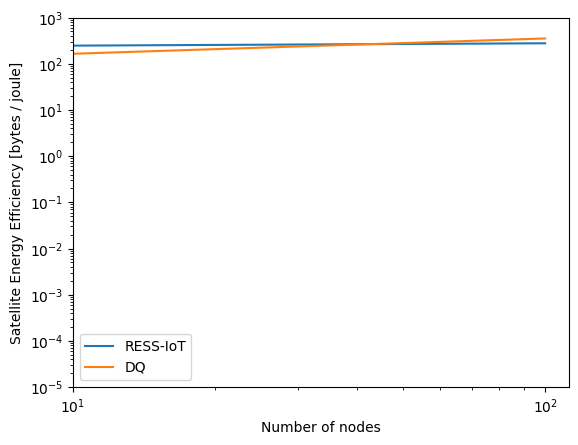

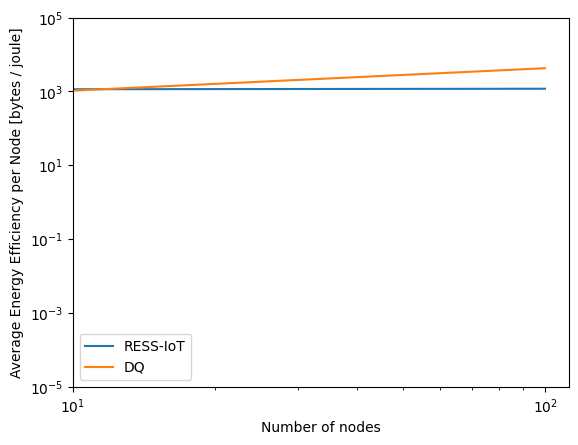

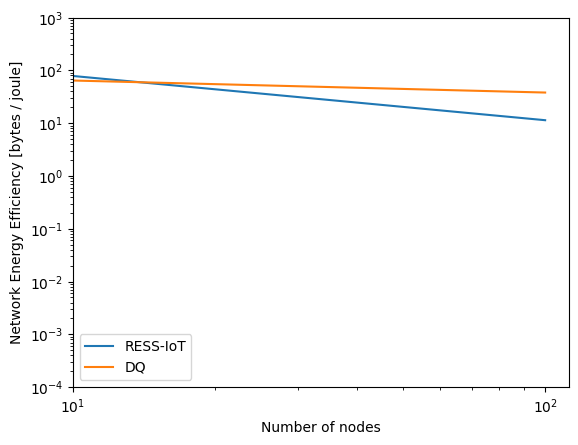

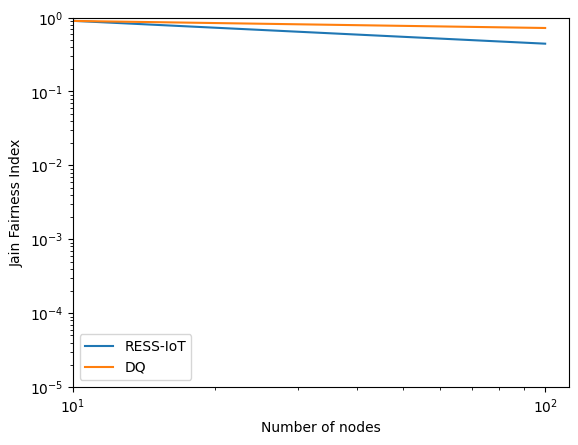

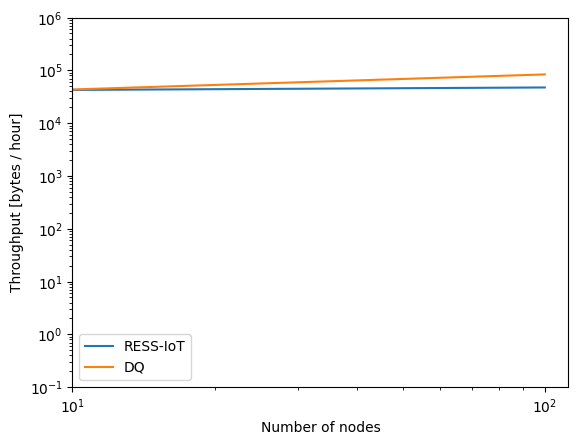

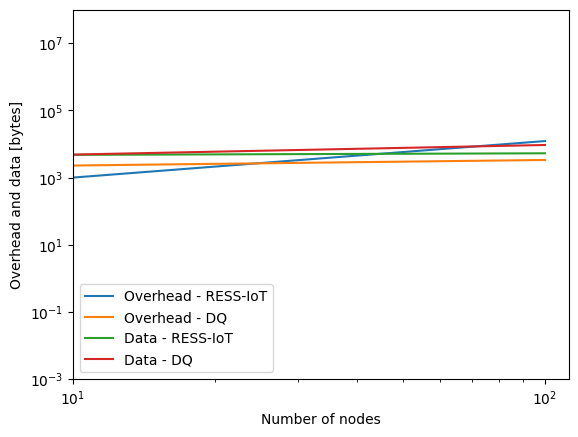

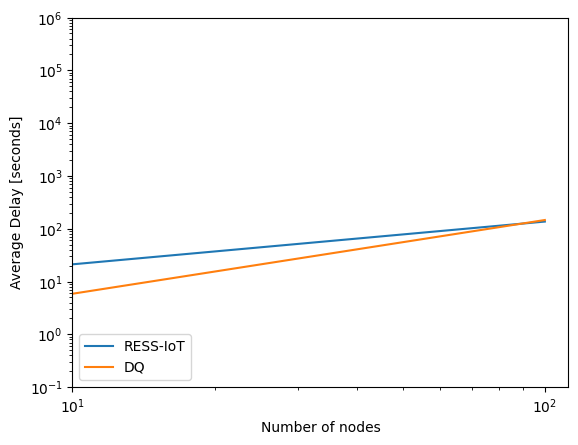

In [13]:
metrics = {}

for key in dfs:
    metrics[key] = {}
    
    for node_count in dfs[key]["SCA"]:
        metrics[key][node_count] = {
            "Average Delay [seconds]": [],
            "Jain Fairness Index": [],
            "Throughput [bytes / hour]": [],
            "Overhead": [],
            "Data": [],
            "Satellite Energy Efficiency [bytes / joule]": [],
            "Average Energy Efficiency per Node [bytes / joule]": [],
            "Network Energy Efficiency [bytes / joule]": [],
        }
        
        for df_sca, df_vec in zip(dfs[key]["SCA"][node_count], dfs[key]["VEC"][node_count]):            
            metrics[key][node_count]["Average Delay [seconds]"].append(get_avg_delay(df_sca, df_vec))
            metrics[key][node_count]["Jain Fairness Index"].append(get_jfi(df_sca))
            metrics[key][node_count]["Throughput [bytes / hour]"].append(get_throughput_bytes_per_hour(df_sca))
            metrics[key][node_count]["Overhead"].append(get_overhead_bytes(df_sca))
            metrics[key][node_count]["Data"].append(get_data_bytes(df_sca))
            metrics[key][node_count]["Satellite Energy Efficiency [bytes / joule]"].append(get_energy_efficiency_satellite(key, df_sca, df_vec))
            metrics[key][node_count]["Average Energy Efficiency per Node [bytes / joule]"].append(get_avg_energy_efficiency_node(key, df_sca, df_vec))
            metrics[key][node_count]["Network Energy Efficiency [bytes / joule]"].append(get_energy_efficiency_network(key, df_sca, df_vec))
                
        for metric in metrics[key][node_count]:
            metrics[key][node_count][metric] = sum(metrics[key][node_count][metric]) / len(metrics[key][node_count][metric])
        
pprint.pprint(metrics)

output_dir = "output_graphs"

##### Satellite Energy Efficiency [bytes / joule]
metric = "Satellite Energy Efficiency [bytes / joule]"

for key in dfs:    
    x = metrics[key].keys()
    y = [metrics[key][node_count][metric] for node_count in x]
    plt.plot(x, y, label=key)

plt.ylabel(metric)
plt.xlabel("Number of nodes")
plt.legend(loc="lower left")
plt.yscale("log")  
plt.xscale("log")  
plt.ylim(0.00001, 1000)
plt.xlim(xmin=10)

plt.savefig(os.path.join(output_dir, f"{metric.replace(' ', '_').replace('/', '_')}.png"))
plt.show()

##### Average Energy Efficiency per Node [bytes / joule]
metric = "Average Energy Efficiency per Node [bytes / joule]"

for key in dfs:   
    x = metrics[key].keys()
    y = [metrics[key][node_count][metric] for node_count in x]
    plt.plot(x, y, label=key)

plt.ylabel(metric)
plt.xlabel("Number of nodes")
plt.legend(loc="lower left")
plt.yscale("log")  
plt.xscale("log")  
plt.ylim(0.00001, 100000)
plt.xlim(xmin=10)

plt.savefig(os.path.join(output_dir, f"{metric.replace(' ', '_').replace('/', '_')}.png"))
plt.show()

##### Network Energy Efficiency [bytes / joule]
metric = "Network Energy Efficiency [bytes / joule]"

for key in dfs:
    x = metrics[key].keys()
    y = [metrics[key][node_count][metric] for node_count in x]
    plt.plot(x, y, label=key)

plt.ylabel(metric)
plt.xlabel("Number of nodes")
plt.legend(loc="lower left")
plt.yscale("log")  
plt.xscale("log")
plt.ylim(0.0001, 1000)
plt.xlim(xmin=10)

plt.savefig(os.path.join(output_dir, f"{metric.replace(' ', '_').replace('/', '_')}.png"))
plt.show()

##### Jain Fairness Index
metric = "Jain Fairness Index"

for key in dfs:
    x = metrics[key].keys()
    y = [metrics[key][node_count][metric] for node_count in x]
    plt.plot(x, y, label=key)

plt.ylabel(metric)
plt.xlabel("Number of nodes")
plt.legend(loc="lower left")
plt.yscale("log")  
plt.xscale("log")  
plt.ylim(0.00001, 1)
plt.xlim(xmin=10)

plt.savefig(os.path.join(output_dir, f"{metric.replace(' ', '_').replace('/', '_')}.png"))
plt.show()

##### Throughput bytes / hour
metric = "Throughput [bytes / hour]"

for key in dfs:
    x = metrics[key].keys()
    y = [metrics[key][node_count][metric] for node_count in x]
    plt.plot(x, y, label=key)

plt.ylabel(metric)
plt.xlabel("Number of nodes")
plt.legend(loc="lower left")
plt.yscale("log")  
plt.xscale("log")  
plt.ylim(0.1, 1000000)
plt.xlim(xmin=10)

plt.savefig(os.path.join(output_dir, f"{metric.replace(' ', '_').replace('/', '_')}.png"))
plt.show()

##### Overhead and data [bytes]
metric = "Overhead"

for key in dfs:
    x = metrics[key].keys()
    y = [metrics[key][node_count][metric] for node_count in x]
    plt.plot(x, y, label=f"{metric} - {key}")
    
metric = "Data"

for key in dfs:
    x = metrics[key].keys()
    y = [metrics[key][node_count][metric] for node_count in x]
    plt.plot(x, y, label=f"{metric} - {key}")

plt.ylabel("Overhead and data [bytes]")
plt.xlabel("Number of nodes")
plt.legend(loc="lower left")
plt.yscale("log")  
plt.xscale("log")  
plt.ylim(0.001, 100000000)
plt.xlim(xmin=10)

plt.savefig(os.path.join(output_dir, f"{'Overhead and data [bytes]'.replace(' ', '_').replace('/', '_')}.png"))
plt.show()

##### Average Delay [seconds]
metric = "Average Delay [seconds]"

for key in dfs:
    x = metrics[key].keys()
    y = [metrics[key][node_count][metric] for node_count in x]
    plt.plot(x, y, label=key)

plt.ylabel(metric)
plt.xlabel("Number of nodes")
plt.legend(loc="lower left")
plt.yscale("log")  
plt.xscale("log")  
plt.ylim(0.1, 1000000)
plt.xlim(xmin=10)

plt.savefig(os.path.join(output_dir, f"{metric.replace(' ', '_').replace('/', '_')}.png"))
plt.show()